In [1]:
import os
os.chdir("/home/user/src")
os.listdir()

['model.py',
 'notebooks',
 'aux',
 'train.py',
 'configs',
 '__pycache__',
 'utils.py',
 'main.py',
 'dataset.py']

In [2]:
import torch
import hydra
import omegaconf
import rasterio as rio
import glob
import math

import torch
import torch.nn as nn
import numpy as np


import matplotlib.pyplot as plt
from utils import preprocess_s2, s2toRGB

# settings

In [3]:
checkpoint = "/home/user/results/vit_8x8/2024-09-25_08:18:44/model_checkpoints/checkpoint_100_39000.pt"
configdir = "./configs/vit_8x8.yaml"
data_topdir = "/home/user/datainference"

# init the model and load weights

In [4]:
cfg = omegaconf.OmegaConf.load(configdir)
model = hydra.utils.instantiate(cfg.model)

In [5]:
state_dict = torch.load(checkpoint,map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model_state_dict"])
model.eval()

pass

# load a S2 image

In [6]:
classnames = ["AnnualCrop","HerbaceousVegetation","Industrial",
              "PermanentCrop","River","Forest","Highway",
              "Pasture","Residential","SeaLake"]


samples = {}
for cn in classnames:
    samples[cn] = glob.glob(os.path.join(data_topdir,"**",f"*{cn}*.tif"),recursive=True)

data shape (13, 64, 64)


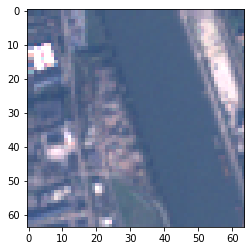

In [7]:
N = 100

with rio.open(samples["River"][N], "r") as src:
    data = preprocess_s2( src.read() )

print("data shape", data.shape)

plt.imshow(s2toRGB(data))
plt.show()

# inference

In [8]:
x = torch.tensor(data,dtype=torch.float32).unsqueeze(0)

In [9]:
cls, feat = model(x)

In [10]:
cls

tensor([[-3.1471,  0.9223,  0.4492, -2.1053,  9.1942, -3.0012,  0.6428, -1.1287,
         -1.6414,  1.9018]], grad_fn=<AddmmBackward0>)

In [11]:
cls.argmax()

tensor(4)

In [12]:
feat.shape

torch.Size([1, 65, 768])

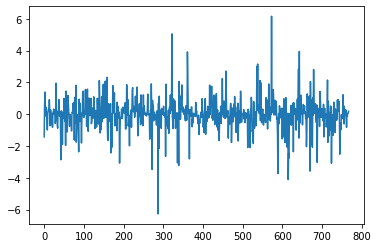

In [13]:
plt.plot(feat[0,2].detach().numpy())
plt.show()

# look at weights

In [14]:
for key in state_dict["model_state_dict"].keys():
    if "transformer.layers.0" in key:
        print(key,state_dict["model_state_dict"][key].shape)

transformer.layers.0.self_attn.in_proj_weight torch.Size([2304, 768])
transformer.layers.0.self_attn.in_proj_bias torch.Size([2304])
transformer.layers.0.self_attn.out_proj.weight torch.Size([768, 768])
transformer.layers.0.self_attn.out_proj.bias torch.Size([768])
transformer.layers.0.linear1.weight torch.Size([2048, 768])
transformer.layers.0.linear1.bias torch.Size([2048])
transformer.layers.0.linear2.weight torch.Size([768, 2048])
transformer.layers.0.linear2.bias torch.Size([768])
transformer.layers.0.norm1.weight torch.Size([768])
transformer.layers.0.norm1.bias torch.Size([768])
transformer.layers.0.norm2.weight torch.Size([768])
transformer.layers.0.norm2.bias torch.Size([768])


# attention patterns

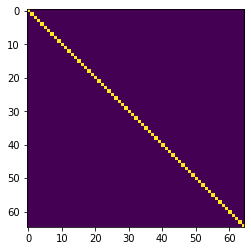

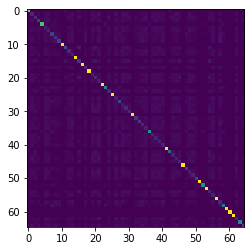

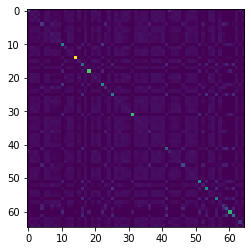

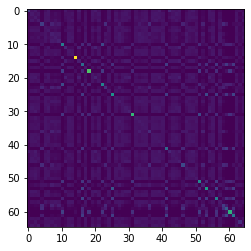

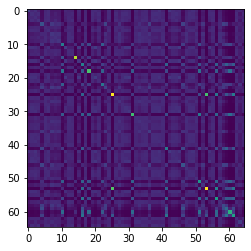

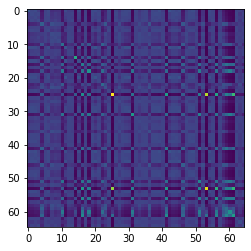

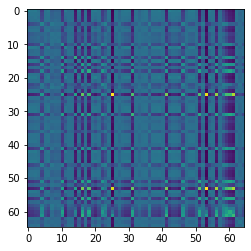

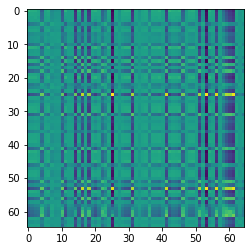

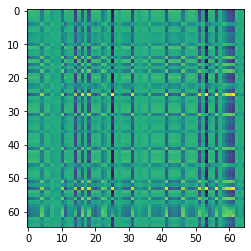

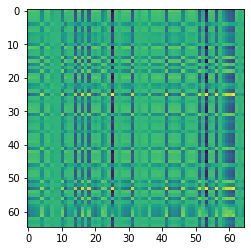

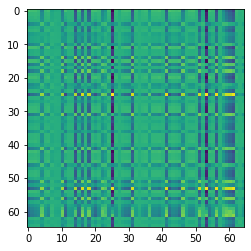

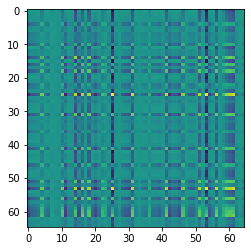

In [15]:
for layer in range(12):

    def attention_hook(module, input, output):
        # Extract the query, key, and value tensors
        query, key, value = input
    
        # Calculate the attention scores without multiplication
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.shape[-1])
    
        # Access the attention matrix
        attention_matrix = torch.softmax(attention_scores, dim=-1)
    
        # Append the attention matrix to the list
        plt.imshow(attention_matrix[0])
        plt.show()
    
    # Register the hook
    hook = model.transformer.layers[layer].self_attn.register_forward_hook(attention_hook)
    
    # ... rest of your code ...
    with torch.no_grad():
        output, _ = model(x)
    # Remove the hook after you're done
    
    hook.remove()